# Training Log Analysis
Questo notebook carica `training_log.csv` prodotto da `train.py` e mostra le curve di loss per train/val/test. Modifica il percorso in base alla run che vuoi ispezionare.

In [7]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


LOG_PATH = Path('../outputs/runs/exp1/training_log.csv')
log_df = pd.read_csv(LOG_PATH)
display(log_df.head())


,epoch,train_loss,train_heatmap_loss,train_presence_loss,val_loss,val_heatmap_loss,val_presence_loss,test_loss,test_heatmap_loss,test_presence_loss
0,1,0.725486,0.346943,0.378544,0.252106,0.001500,0.250605,NaN,NaN,NaN
1,2,0.054298,0.001789,0.052508,0.174485,0.001440,0.173044,NaN,NaN,NaN
2,3,0.023458,0.001655,0.021803,0.069676,0.002260,0.067415,NaN,NaN,NaN
3,4,0.014195,0.001449,0.012746,0.031589,0.001423,0.030166,NaN,NaN,NaN
4,5,0.009967,0.001411,0.008555,0.014778,0.001388,0.013391,NaN,NaN,NaN


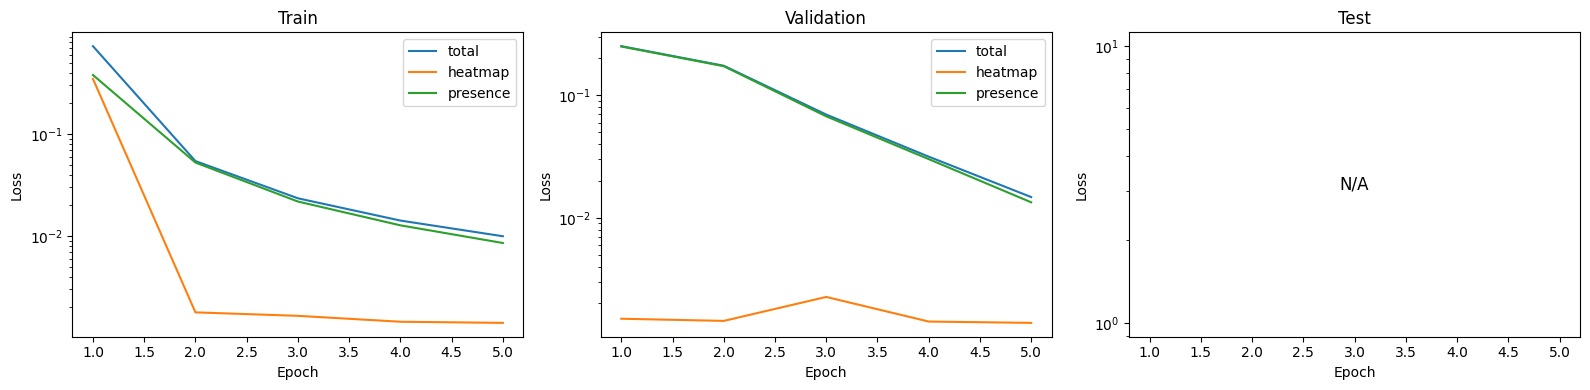

In [8]:
splits = {
    
    'Train': ('train_loss', 'train_heatmap_loss', 'train_presence_loss'),
    'Validation': ('val_loss', 'val_heatmap_loss', 'val_presence_loss'),
    'Test': ('test_loss', 'test_heatmap_loss', 'test_presence_loss')
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
for ax, (title, cols) in zip(axes, splits.items()):
    epochs = log_df['epoch']
    plotted = False
    for metric, label in zip(cols, ('total', 'heatmap', 'presence')):
        series = log_df[metric]
        if series.notna().any():
            ax.plot(epochs, series, label=label)
            plotted = True
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if plotted:
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'N/A', transform=ax.transAxes, ha='center', va='center', fontsize=12)

    ax.set_yscale('log')
    
plt.tight_layout()
plt.show()

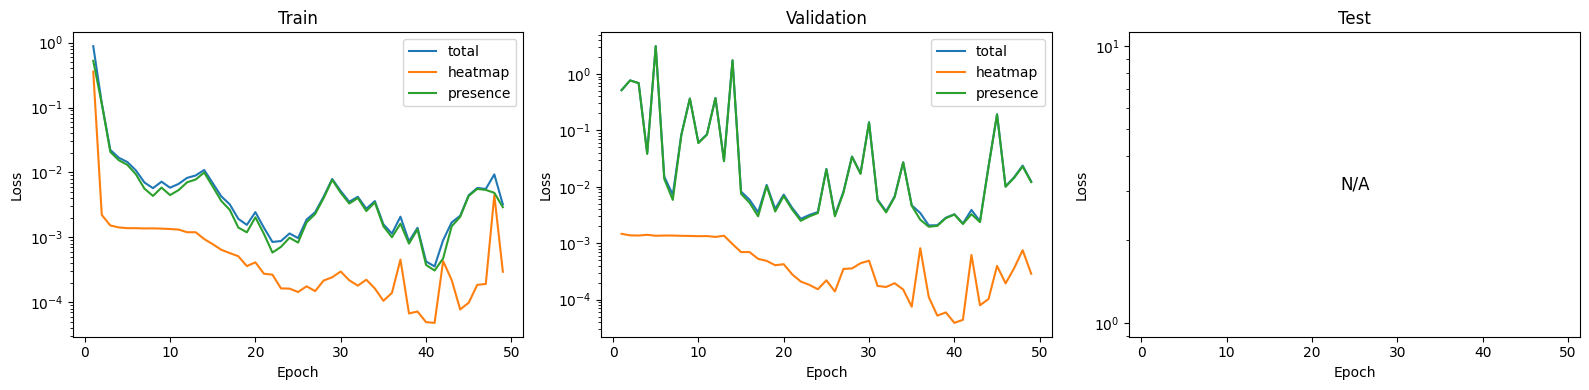

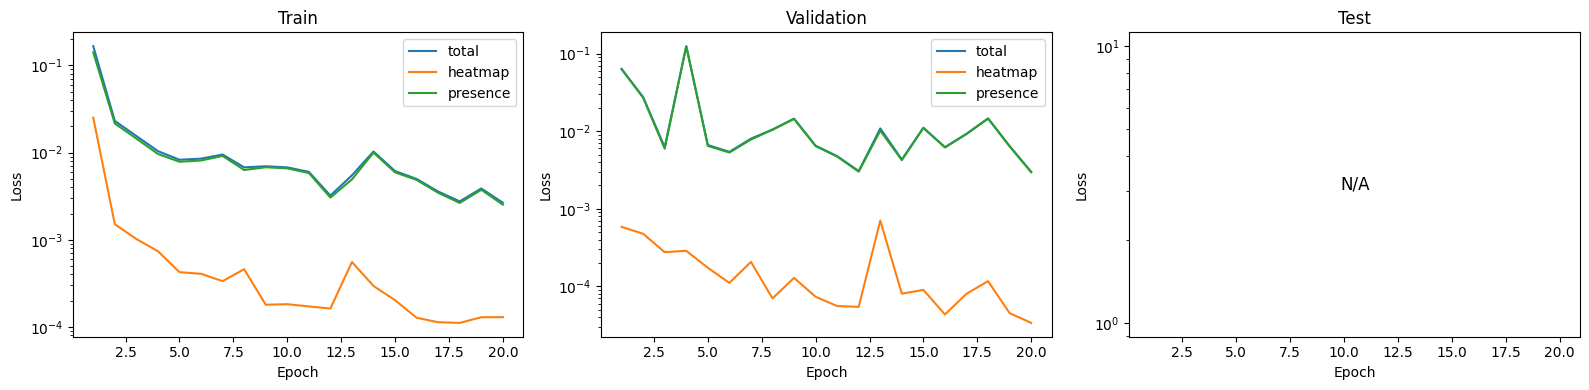

## Eval metrics
Queste celle consumano `outputs/preds/metrics.json` e le curve PR/ROC generate da `infer.py` per dare un colpo d'occhio alle prestazioni sul manifest di valutazione.

In [3]:
from pathlib import Path
import json
import pandas as pd

METRICS_PATH = Path('../outputs/preds/metrics.json')
if not METRICS_PATH.exists():
    raise FileNotFoundError(f'Metrics file not found: {METRICS_PATH}')

with open(METRICS_PATH) as f:
    eval_metrics = json.load(f)

presence = eval_metrics.get('presence_metrics', {})
presence_summary = pd.DataFrame([{
    'AUPRC': presence.get('auprc'),
    'ROC_AUC': presence.get('roc_auc'),
    'Precision@τ': presence.get('precision_at_tau'),
    'Recall@τ': presence.get('recall_at_tau'),
    'F1@τ': presence.get('f1_at_tau'),
    'τ usata': presence.get('threshold')
}])
display(presence_summary)

conf = presence.get('confusion_matrix', {})
conf_df = pd.DataFrame(
    [[conf.get('tp', 0), conf.get('fp', 0)],
     [conf.get('fn', 0), conf.get('tn', 0)]],
    index=['GT=1', 'GT=0'],
    columns=['Pred=1', 'Pred=0']
)
display(conf_df)

center_px = eval_metrics.get('center_metrics_px')
if center_px:
    center_summary = pd.DataFrame([{
        'Policy': center_px.get('policy'),
        'Count': center_px.get('count'),
        'MAE (px)': center_px.get('mae_px'),
        'MedAE (px)': center_px.get('medae_px'),
    }])
    display(center_summary)
    pct_within = center_px.get('pct_within_px', {})
    if pct_within:
        pct_df = pd.DataFrame.from_dict(pct_within, orient='index', columns=['% ≤ soglia'])
        pct_df.index = pct_df.index.astype(float)
        pct_df = pct_df.sort_index()
        display(pct_df)
else:
    print('Center metrics (px) non presenti nel JSON: verifica le opzioni di inferenza.')

center_km = eval_metrics.get('center_metrics_km')
if center_km:
    center_km_summary = pd.DataFrame([{
        'Policy': center_km.get('policy'),
        'Count': center_km.get('count'),
        'MAE (km)': center_km.get('mae_km'),
        'MedAE (km)': center_km.get('medae_km'),
    }])
    display(center_km_summary)
    pct_within_km = center_km.get('pct_within_km', {})
    if pct_within_km:
        pct_km_df = pd.DataFrame.from_dict(pct_within_km, orient='index', columns=['% ≤ soglia'])
        pct_km_df.index = pct_km_df.index.astype(float)
        pct_km_df = pct_km_df.sort_index()
        display(pct_km_df)
elif center_km is not None:
    print('Center metrics (km) presenti ma vuote, controlla km_per_px.')
else:
    print('Center metrics (km) non presenti nel JSON: passa --km-per-px in inferenza per abilitarle.')

FileNotFoundError: Metrics file not found: ../outputs/preds/metrics.json

### Curve PR e ROC
Se `--sweep-curves DIR` era attivo durante l'inferenza, le curve vengono salvate in CSV e visualizzate qui.

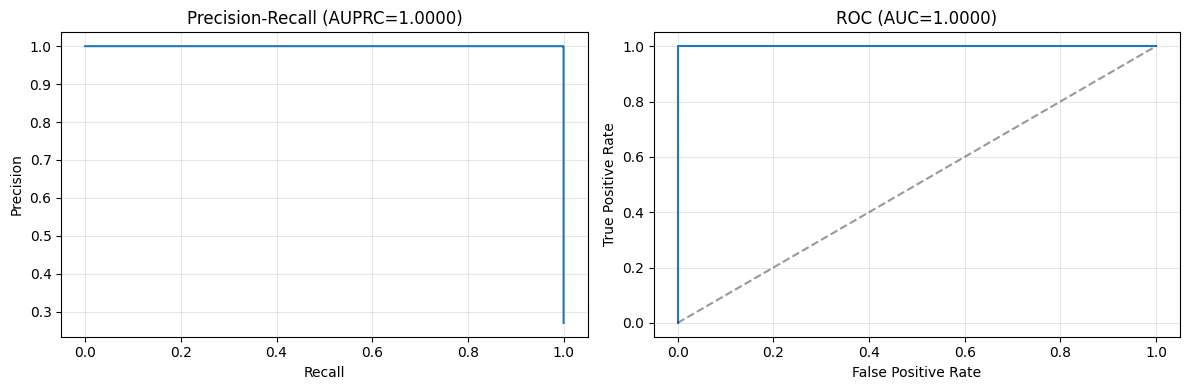

In [14]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

CURVES_DIR = Path('../outputs/preds/curves')
pr_path = CURVES_DIR / 'pr_curve.csv'
roc_path = CURVES_DIR / 'roc_curve.csv'

if not pr_path.exists() or not roc_path.exists():
    raise FileNotFoundError('Curve PR/ROC non trovate: assicurati di aver passato --sweep-curves.')

pr_df = pd.read_csv(pr_path)
roc_df = pd.read_csv(roc_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(pr_df['recall'], pr_df['precision'])
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f"Precision-Recall (AUPRC={pr_df['pr_auc'].dropna().iloc[0]:.4f})")
axes[0].grid(True, alpha=0.3)

axes[1].plot(roc_df['fpr'], roc_df['tpr'])
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f"ROC (AUC={roc_df['roc_auc'].dropna().iloc[0]:.4f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()